# Library: `sklearn.linear_models`

In this lab we demonstrate how the `sklearn.linear_models` library can be used to fit simple linear models.\

We consider both the Regression and Classidication settings.\

* **Regression Setting**
    1. Linear Regression
    2. Ridge Regression
    3. LASSO
    4. Elastic Net


* **Classification Setting**
   1. Logistic Regression
   2. Support Vector Machine

# Regression Setting

For the Regression setting we use the `Boston` dataset, which is described below:

The Boston Housing Dataset is a derived from information collected by the U.S. Census Service concerning housing in the area of Boston MA. The dataset has the following variables:

`CRIM` - per capita crime rate by town\
`ZN` - proportion of residential land zoned for lots over 25,000 sq.ft.\
`INDUS` - proportion of non-retail business acres per town.\
`CHAS` - Charles River dummy variable (1 if tract bounds river; 0 otherwise)\
`NOX` - nitric oxides concentration (parts per 10 million)\
`RM` - average number of rooms per dwelling\
`AGE` - proportion of owner-occupied units built prior to 1940\
`DIS` - weighted distances to five Boston employment centres\
`RAD` - index of accessibility to radial highways\
`TAX` - full-value property-tax rate per 10,000\
`PTRATIO` -  pupil-teacher ratio by town\
`B` - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town\
`LSTAT` - % lower status of the population\
`MEDV` - Median value of owner-occupied homes in 1000's\


The goal is to enseble a linear model with a combination of the above features in order to predict the reponse `MEDV`.

In [ ]:
import os
import numpy as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import *

In [ ]:

# Load and display the dataset
path = os.getcwd() + "\Boston.csv"
data = pd.read_csv(path)

# Drop the 1st column which is just the indices
data.drop(data.columns[0], axis = 1, inplace = True)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [ ]:

# Extract the features and the response
features = data.columns.tolist()

# Response
response = "medv"

features.remove(response)

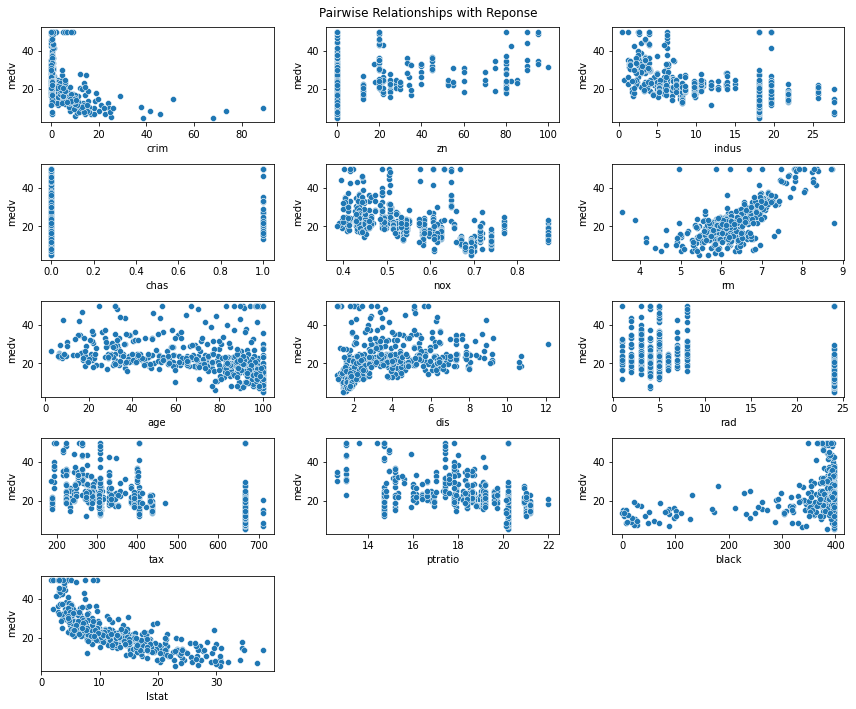

In [ ]:

# Visual examination of the data
fig, axs = plt.subplots(5, 3, figsize = (12, 10))

axs = axs.flatten()

for i, feature in enumerate(features):

    sns.scatterplot(data = data, x = feature, y = response, ax = axs[i])

fig.delaxes(axs[-1])
fig.delaxes(axs[-2])
plt.suptitle("Pairwise Relationships with Reponse")
plt.tight_layout()
plt.show()


## Data Pre-processing

Here we standardize the features and split the data into train and test sets to evaluate the models' performances using some functionality from the `sklearn.model_selection` module.


In [ ]:

# Import the pre-processing routines
from sklearn.model_selection import (KFold, GridSearchCV,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler

import sklearn.linear_model

In [ ]:

# Standardize the Model Features
data[features] = StandardScaler().fit_transform(data[features])

# Make a hold-out split to training and test sets
test_size = 0.2
train_set, test_set =  train_test_split(data, test_size = test_size,
                                        random_state = 919, shuffle = True)



## Linear Regression

In [ ]:

# Create the Linear Regression model object
LR = sklearn.linear_model.LinearRegression()

# Fit the Model on the Traing set
linear_model = LR.fit(train_set[features], train_set[response])


In [ ]:

# Extract the model's estimated coefficients
linear_model.coef_

array([-0.93160942,  1.30376439,  0.25951548,  0.80028902, -2.4472249 ,
        1.98836985,  0.10081332, -3.70797803,  2.90045398, -2.04005442,
       -2.20976095,  0.94628577, -4.12610562])

In [ ]:

# Evaluate the model's performance on the test set

# Create the predictions
y_hat = linear_model.predict(test_set[features])

# Estimate the Test MSE
test_mse = ((test_set[response] - y_hat) ** 2).mean()

print(f"\n The Estimated Test MSE of the Linear Regression model is: {test_mse}")



 The Estimated Test MSE of the Linear Regression model is: 20.837956372959535


## Ridge Regression

The issues with the plain linear regression model is that it does not employ regularization, so we do not have controls over the model's flexibility.\

In general we use the `ElasticNet` routine from the `sklearn.linear_model` module to fit Ridge, LASSO, and Elastic Net models. In the original R formulation through `glmnet`, elastic net solves the constrained optimization problem:

$$\hat{b}^{EN}=\underset{b}{argmin}\left(\|Y-Xb\|^2_2+\alpha \lambda \|b\|_1+(1-\alpha) \lambda \|b\|_2^2\right),$$

for $\lambda\geq0$ which defines the strenght of the penalty term and $\alpha\in[0,1].$

* When $\alpha=0$, we have a Ridge regression and
* When $\alpha = 1$, we have LASSO regression.

In the `sklearn` formulation we have $\alpha=$ `l1_ratio` which is the mixing partameter between the Ridge and LASSO regressions and $\lambda=$`alpha` which defines the strength of the penalty/constraint region.


Before we train the Ridge model we have to tune for the $L_2$ penalazing hyperparameter $\lambda$.\
To do so, we create a grid of $\lambda$ values and we search for the one that provides the lowest Test Mse.\
To avoid overfitting, the procedure is implemented exclusively on the training set, which is further split into internal train set and validation sets\.

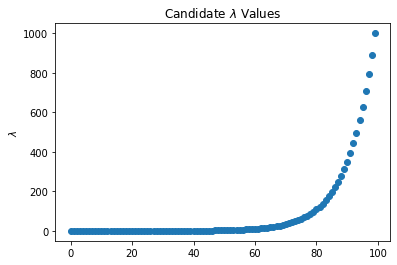

In [ ]:
# Create candidate lambda values
lamda = np.logspace(-2, 3, base = 10, num = 100)
plt.plot(lamda, ls = "", marker = "o")
plt.title("Candidate $\lambda$ Values")
plt.ylabel("$\lambda$")
plt.show()

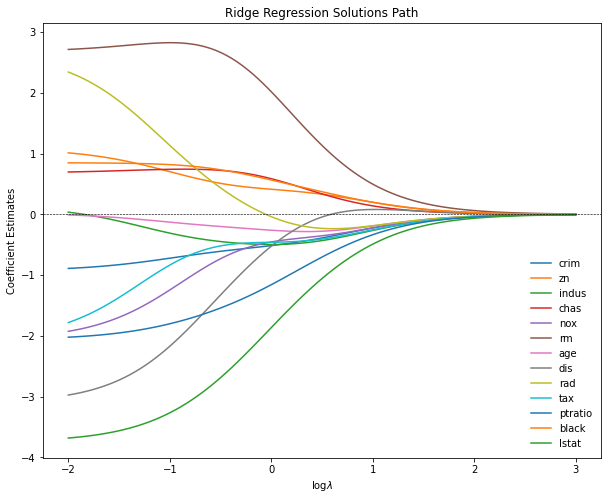

In [ ]:

#Supress coordinate descent warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import ElasticNet

# Fit ridge regression paths
ridge_solution_paths = ElasticNet.path(data[features], data[response], l1_ratio = 0,  alphas = lamda)[1]
ridge_solution_paths.shape

# Plotting the ridge regression paths
ridge_solutions = pd.DataFrame(ridge_solution_paths.T,
                               index = np.log10(lamda)[::-1],
                               columns = data[features].columns)

ridge_solutions.index.rename("lamda", inplace=True)

ridge_solutions.plot(figsize=(10, 8))
plt.axhline(y = 0, ls="--", linewidth = 0.6, c = "black")
plt.title("Ridge Regression Solutions Path")
plt.xlabel("log$\lambda$")
plt.ylabel("Coefficient Estimates")
plt.legend(loc = "lower right", frameon = False)
plt.show()

We can tune the model hyperparameter $\lambda$ using the exhaustive `GridSearchCV` routine that selects the best model based on the cross-validated Test MSE.

In [ ]:
# Specify the folds for the CV in the tuning step
k = 10
folds = KFold(k, shuffle = True)

# First we specify the unfitted model
ridge = ElasticNet(alpha = 50, l1_ratio = 0, fit_intercept = True)

# Define the hyperparameter grid
hyper_grid = {"alpha": lamda}

model_tune = GridSearchCV(ridge, hyper_grid, cv = folds, scoring = "neg_mean_squared_error")
model_tune

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=ElasticNet(alpha=50, l1_ratio=0),
             param_grid={'alpha': array([1.00000000e-02, 1.12332403e-02, 1.26185688e-02, 1.41747416e-02,
       1.59228279e-02, 1.78864953e-02, 2.00923300e-02, 2.25701972e-02,
       2.53536449e-02, 2.84803587e-02, 3.19926714e-02, 3.59381366e-02,
       4.03701726e-02, 4.53487851e-02, 5.094...
       6.89261210e+01, 7.74263683e+01, 8.69749003e+01, 9.77009957e+01,
       1.09749877e+02, 1.23284674e+02, 1.38488637e+02, 1.55567614e+02,
       1.74752840e+02, 1.96304065e+02, 2.20513074e+02, 2.47707636e+02,
       2.78255940e+02, 3.12571585e+02, 3.51119173e+02, 3.94420606e+02,
       4.43062146e+02, 4.97702356e+02, 5.59081018e+02, 6.28029144e+02,
       7.05480231e+02, 7.92482898e+02, 8.90215085e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error')

In [ ]:

# Tune the model on the training dataset
tuned_model = model_tune.fit(data[features], data[response])

# Extract the Average Test MSE
test_mse = -tuned_model.cv_results_["mean_test_score"]

# Compute the standard error of the cross-validated MSE
mse_se = tuned_model.cv_results_["std_test_score"] / sqrt(k)

# Optimal Hyperparameter value
opt_lamda = tuned_model.best_params_["alpha"]

# Extracting the 1-standard error optimal hyperparameter
opt_se = mse_se[test_mse.argmin()]

# Max hyperparameter value that has test mse within 1-SE from the optimal
one_se_opt_lamda = lamda[test_mse <= (test_mse.min() + opt_se)].max()


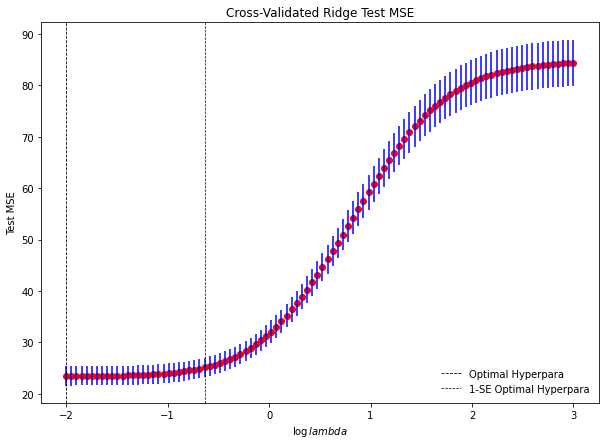

In [ ]:

plt.figure(figsize=(10, 7))
plt.errorbar(x = np.log10(lamda), y = test_mse, yerr = mse_se,
             barsabove = True, ecolor = "blue", c = "r", fmt = "o")

plt.axvline(x = np.log10(opt_lamda), ls="--", linewidth = 0.8, c="black",
           label="Optimal Hyperpara")

plt.axvline(x = np.log10(one_se_opt_lamda), ls = "--", linewidth = 0.7,
           label="1-SE Optimal Hyperpara", c="black")

plt.title("Cross-Validated Ridge Test MSE")
plt.ylabel("Test MSE")
plt.xlabel("$\loglambda$")
plt.legend(frameon=False, loc="lower right")
plt.show()

In [ ]:

# Lastly we fit the tuned model on the training set and evaluate its performance on the test set
ridge_tuned = ElasticNet(alpha = one_se_opt_lamda,
                         l1_ratio = 0,
                         fit_intercept = True).fit(train_set[features], train_set[response])


In [ ]:

# Estimated coefficients
ridge_tuned.coef_

array([-0.64802033,  0.67850767, -0.35119357,  0.86125185, -0.99059696,
        2.35420829, -0.09752944, -1.81918357,  0.7226993 , -0.48859894,
       -1.66358572,  0.85068013, -3.07894965])

In [ ]:

# Evaluate model's performance
y_hat = ridge_tuned.predict(test_set[features])

# Test MSE
test_mse_ridge = ((test_set[response] - y_hat) ** 2).mean()

print(f"\n The Estimated Test MSE of the Ridge Regression model is: {test_mse_ridge}")


 The Estimated Test MSE of the Ridge Regression model is: 19.04259341548068


## LASSO Regression

The problem with Ridge, is that while it performs regularization and it shrinks some coefficient towards zeor, it does not perform feature selection.\

For feature selection we can use LASSO regression.

Similarly, by setting $\alpha=1$ (`l1_ratio`), we obtain the LASSO regression.

In [ ]:
# Fit LASSO regression paths
lasso_solution_paths = ElasticNet.path(data[features], data[response], l1_ratio = 1,  alphas = lamda)[1]

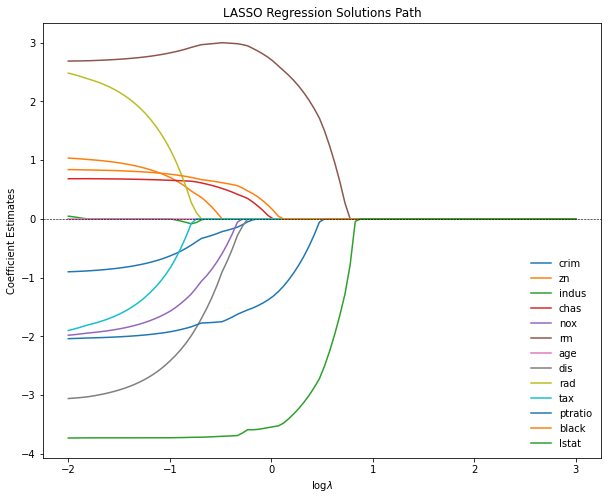

In [ ]:
# Plotting the ridge regression paths
lasso_solutions = pd.DataFrame(lasso_solution_paths.T,
                               index = np.log10(lamda)[::-1],
                               columns = data[features].columns)

lasso_solutions.index.rename("lamda", inplace=True)

lasso_solutions.plot(figsize=(10, 8))
plt.axhline(y = 0, ls="--", linewidth = 0.6, c = "black")
plt.title("LASSO Regression Solutions Path")
plt.xlabel("log$\lambda$")
plt.ylabel("Coefficient Estimates")
plt.legend(loc = "lower right", frameon = False)
plt.show()

In [ ]:
# Specify the folds for the CV in the tuning step
k = 10
folds = KFold(k, shuffle = True)

# Specify an unfitted LASSO object
lasso = ElasticNet(l1_ratio = 1)

# Define the hyperparameter grid
hyper_grid = {"alpha": lamda}

model_tune = GridSearchCV(lasso, hyper_grid, cv = folds, scoring = "neg_mean_squared_error")
model_tune

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': array([1.00000000e-02, 1.12332403e-02, 1.26185688e-02, 1.41747416e-02,
       1.59228279e-02, 1.78864953e-02, 2.00923300e-02, 2.25701972e-02,
       2.53536449e-02, 2.84803587e-02, 3.19926714e-02, 3.59381366e-02,
       4.03701726e-02, 4.53487851e-02, 5.09413801e-02...
       6.89261210e+01, 7.74263683e+01, 8.69749003e+01, 9.77009957e+01,
       1.09749877e+02, 1.23284674e+02, 1.38488637e+02, 1.55567614e+02,
       1.74752840e+02, 1.96304065e+02, 2.20513074e+02, 2.47707636e+02,
       2.78255940e+02, 3.12571585e+02, 3.51119173e+02, 3.94420606e+02,
       4.43062146e+02, 4.97702356e+02, 5.59081018e+02, 6.28029144e+02,
       7.05480231e+02, 7.92482898e+02, 8.90215085e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error')

In [ ]:

# Tune the model on the whole dataset
tuned_model = model_tune.fit(train_set[features], train_set[response])

# Extract the Average Test MSE
test_mse = -tuned_model.cv_results_["mean_test_score"]

# Compute the standard error of the cross-validated MSE
mse_se = tuned_model.cv_results_["std_test_score"] / sqrt(k)

# Optimal Hyperparameter value
opt_lamda = tuned_model.best_params_["alpha"]

# Extracting the 1-standard error optimal hyperparameter
opt_se = mse_se[test_mse.argmin()]

# Max hyperparameter value that has test mse within 1-SE from the optimal
one_se_opt_lamda = lamda[test_mse <= (test_mse.min() + opt_se)].max()

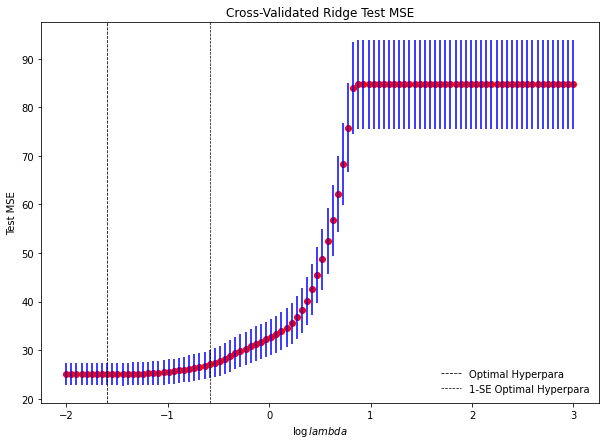

In [ ]:
plt.figure(figsize=(10, 7))
plt.errorbar(x = np.log10(lamda), y = test_mse, yerr = mse_se,
             barsabove = True, ecolor = "blue", c = "r", fmt = "o")

plt.axvline(x = np.log10(opt_lamda), ls="--", linewidth = 0.8, c="black",
           label="Optimal Hyperpara")

plt.axvline(x = np.log10(one_se_opt_lamda), ls = "--", linewidth = 0.7,
           label="1-SE Optimal Hyperpara", c="black")

plt.title("Cross-Validated Ridge Test MSE")
plt.ylabel("Test MSE")
plt.xlabel("$\loglambda$")
plt.legend(frameon=False, loc="lower right")
plt.show()

In [ ]:
print(f"\nThe optimal lamda is: {opt_lamda:.3f} while the 1-SE optimal lamda is: {one_se_opt_lamda:.4f}")


The optimal lamda is: 0.025 while the 1-SE optimal lamda is: 0.2595


In [ ]:
# Lastly we fit the tuned model on the training set and evaluate its performance on the test set
lasso_tuned = ElasticNet(alpha = one_se_opt_lamda,
                         l1_ratio = 1,
                         fit_intercept = True).fit(train_set[features], train_set[response])


In [ ]:

# Estimated coefficients
lasso_tuned.coef_

array([-0.29288252,  0.52428832, -0.        ,  0.73054175, -1.04522517,
        2.33353028, -0.        , -2.02495015,  0.02236528, -0.        ,
       -1.75564256,  0.71409009, -4.02689617])

In [ ]:

# Evaluate model's performance
y_hat = lasso_tuned.predict(test_set[features])

# Test MSE
test_mse_lasso = ((test_set[response] - y_hat) ** 2).mean()

print(f"\n The Estimated Test MSE of the Ridge Regression model is: {test_mse_lasso}")


 The Estimated Test MSE of the Ridge Regression model is: 19.037435472295247


## Elastic Net

Lastly, we fit the Elastic Net model which contains a combination of $L_1$ and $L_2$ penalties.\
We fit the elastic using the fucntion `Elastic_Net` as before, except that now the hyperparameter `l1_ratio` should take values between 0 and 1, to achieve a mix between LASSO and Ridge Penalties.

We can treat `l1_ratio` as a tuning hyperaparameter as well, in which case we have to tune the model over a 2-Dimensional Grid using `GridSearchCV` as before.\

To easy the computational complexity of searching over a 2-dimensional grid, we set `l1_ratio` = 0.5

In [ ]:

# Define the 2-D hyperparameter grid
l1 = np.linspace(0.1, 0.99, 10)

# Create the 2-D hyperparameter Grid
hyper_grid = {"alpha": lamda}

# Create the ElasticNet model object
elastic_net = ElasticNet(fit_intercept = True)

# Tune the Elastic Net
model_tune = GridSearchCV(elastic_net, hyper_grid, cv = folds, scoring = "neg_mean_squared_error")

# Tune the model on the whole dataset
tuned_model = model_tune.fit(train_set[features], train_set[response])



In [ ]:

# Extract the optimal alpha value
opt_alpha = tuned_model.best_params_["alpha"]

# Fit the tuned model on the training set
elastic_net = ElasticNet(alpha = opt_alpha,
                         fit_intercept = True).fit(train_set[features],
                                                   train_set[response])

# Estimated Coefficients
elastic_net.coef_

array([-0.87910762,  1.19634413,  0.0746108 ,  0.81906535, -2.23541599,
        2.05587125,  0.04063181, -3.53429886,  2.45143317, -1.61825199,
       -2.14342705,  0.93651067, -4.04016269])

In [ ]:

# Evaluate the model's performance on the Test Set

# Evaluate model's performance
y_hat = elastic_net.predict(test_set[features])

# Test MSE
test_mse_en = ((test_set[response] - y_hat) ** 2).mean()

print(f"\n The Estimated Test MSE of the Ridge Regression model is: {test_mse_en}")


 The Estimated Test MSE of the Ridge Regression model is: 20.334456257423643


# Exploratory Data Analysis with Iris Dataset

## Importing Necessary Libraries

The analysis begins by importing essential libraries for data analysis and visualization, including pandas, numpy, matplotlib, seaborn, scipy, and scikit-learn. Various machine learning models from scikit-learn are also imported for potential use in the analysis.

## Loading the Dataset

The Iris dataset is loaded using seaborn's load_dataset function, creating a DataFrame (df) containing information about different iris flowers.

## Visualization: Pairplot to Show Relationships Between Features

A pairplot is created using seaborn to visualize relationships between different features in the dataset. The points are color-coded based on the species of the iris flowers, providing insights into feature distributions and potential patterns.

## Displaying the Last Few Rows of the Dataset

A glimpse of the last few rows of the dataset is displayed to get a quick overview of the data structure.

## Checking the Count of Samples in Each Class

The count of samples for each iris species is calculated to understand the distribution of classes in the dataset.

## Dropping Unnecessary Columns

Certain columns, specifically 'sepal_length' and 'sepal_width', are dropped from the dataset as they may not be relevant for the analysis.

## Descriptive Statistics of the Dataset

Descriptive statistics, including measures like mean, standard deviation, minimum, and maximum values, are calculated to summarize the central tendency and dispersion of the dataset.

## Checking for Null Values in the Dataset

The code checks for the presence of null values in the dataset to ensure data integrity.

## Exploratory Data Analysis - Histograms

Histograms are generated to visualize the distribution of each feature, providing insights into the data's underlying patterns.

## Scatterplot for Sepal Length vs Sepal Width

A scatterplot is created to explore the relationship between sepal length and sepal width, with different iris species distinguished by color.


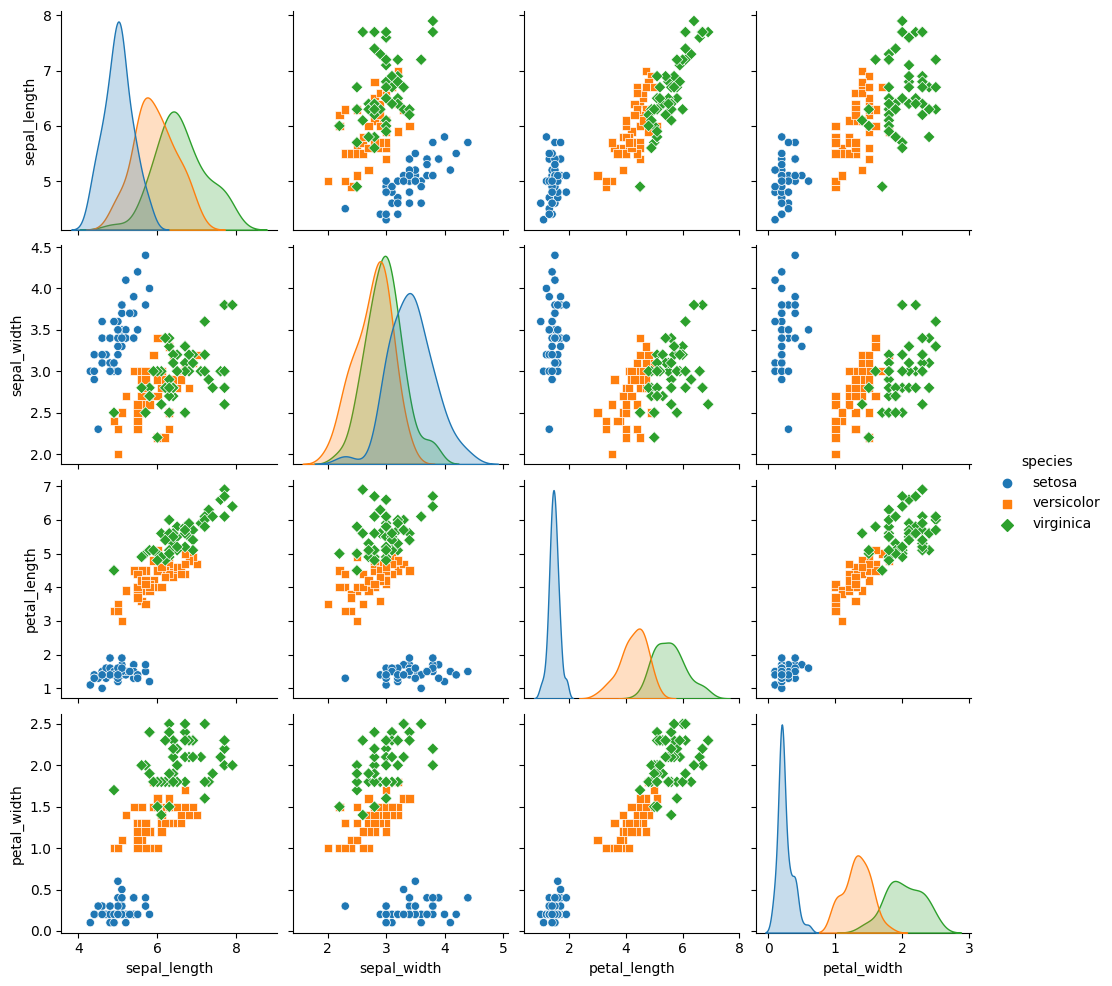

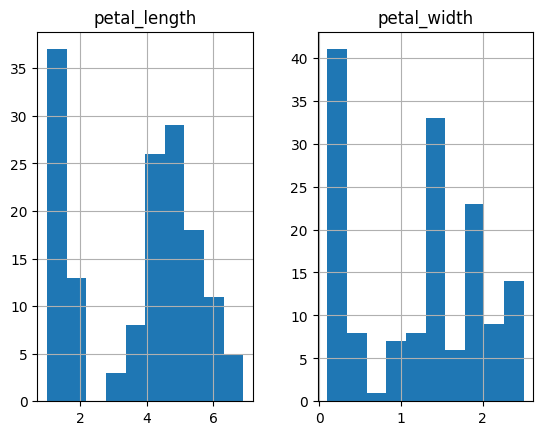

In [ ]:
# Importing necessary libraries
import scipy
import sklearn
from pandas.plotting import scatter_matrix
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Loading the dataset
df = sns.load_dataset('iris')

# Visualization: Pairplot to show relationships between features
sns.pairplot(df, hue='species', markers=["o", "s", "D"])
plt.show()

# Displaying the last few rows of the dataset
df.tail()

# Checking the count of samples in each class
df['species'].value_counts()

# Dropping the 'Id' column
df = df.drop(columns=['sepal_length', 'sepal_width'])
df.head()

# Descriptive statistics of the dataset
df.describe()

# Checking for null values in the dataset
df.isnull().sum()

# Exploratory Data Analysis - Histograms
df.hist()
plt.show()

# Scatterplot for Sepal Length vs Sepal Width
colors = ['red', 'blue', 'green']
species = ['Iris-virginica', 'Iris-versicolor', 'Iris-setosa']




In [ ]:
df.rename(columns={'petal_length': 'sepal_length', 'petal_width': 'sepal_width'}, inplace=True)

# Multiclass Classification with Logistic Regression and Linear SVM

This code performs multiclass classification on the Iris dataset using Logistic Regression and Linear Support Vector Machine (SVM). The steps include data loading, splitting into training and testing sets, training classifiers, visualizing decision boundaries, and evaluating model performance.

## Data Loading and Preprocessing

- The Iris dataset is loaded using `load_iris()` from scikit-learn.
- Only the first two features (`sepal length` and `sepal width`) are selected for visualization (`X = iris.data[:, :2]`).
- The data is split into training and testing sets using `train_test_split()`.

## Classifier Initialization and Training

1. **Logistic Regression:**
   - `LogisticRegression` is initialized with the 'multinomial' option for multiclass classification.
   - The classifier is trained on the training set.

2. **Linear SVM:**
   - `SVC` (Support Vector Classification) with a linear kernel is initialized.
   - The Linear SVM classifier is trained on the training set.

## Visualization of Decision Boundaries

- Decision boundaries for both Logistic Regression and Linear SVM are visualized using contour plots.
- The training and testing data points are plotted on the decision boundaries.

## Model Evaluation

1. **Logistic Regression:**
   - The Logistic Regression model is evaluated on the testing set.
   - Accuracy and a classification report are computed.

2. **Linear SVM:**
   - The Linear SVM model is evaluated on the testing set.
   - Accuracy and a classification report are computed.

## Results and Conclusion

- The accuracy and classification reports for both Logistic Regression and Linear SVM are printed.
- The visualizations help understand how these classifiers differentiate between Iris species based on sepal length and sepal width.

This notebook provides a comprehensive overview of the process of training, visualizing, and evaluating two classifiers for multiclass classification on the Iris dataset.


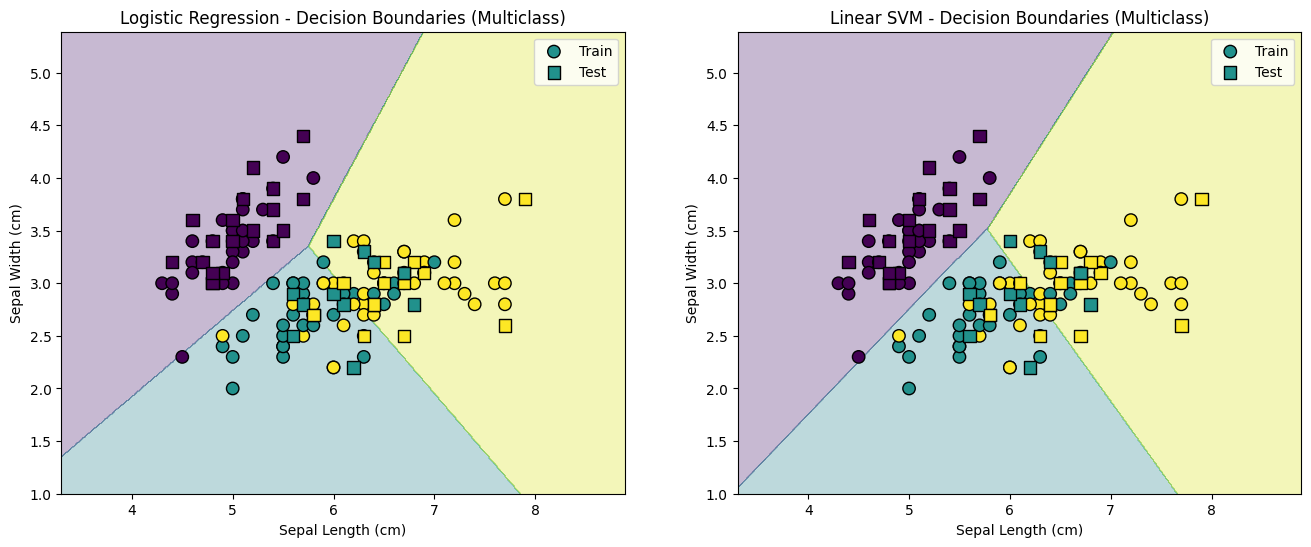

Logistic Regression Accuracy: 0.8222222222222222
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.78      0.54      0.64        13
           2       0.65      0.85      0.73        13

    accuracy                           0.82        45
   macro avg       0.81      0.79      0.79        45
weighted avg       0.83      0.82      0.82        45


Linear SVM Accuracy: 0.8
Linear SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.70      0.54      0.61        13
           2       0.62      0.77      0.69        13

    accuracy                           0.80        45
   macro avg       0.78      0.77      0.77        45
weighted avg       0.81      0.80      0.80        45



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

# Load the iris dataset
iris = load_iris()
X = iris.data[:, :2]  # Using only the first two features for visualization
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Logistic Regression classifier
logreg_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Train the Logistic Regression classifier
logreg_classifier.fit(X_train, y_train)

# Initialize the Linear SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the Linear SVM classifier
svm_classifier.fit(X_train, y_train)

# Visualize the decision boundaries for Logistic Regression
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Decision boundaries for Logistic Regression
Z_logreg = logreg_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z_logreg = Z_logreg.reshape(xx.shape)

# Decision boundaries for Linear SVM
Z_svm = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z_svm = Z_svm.reshape(xx.shape)

# Plotting
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z_logreg, alpha=0.3, cmap='viridis')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolors='k', marker='o', s=80, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', edgecolors='k', marker='s', s=80, label='Test')
plt.title('Logistic Regression - Decision Boundaries (Multiclass)')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.legend()

plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z_svm, alpha=0.3, cmap='viridis')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolors='k', marker='o', s=80, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', edgecolors='k', marker='s', s=80, label='Test')
plt.title('Linear SVM - Decision Boundaries (Multiclass)')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.legend()

plt.show()

# Evaluate Logistic Regression
y_pred_logreg = logreg_classifier.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
classification_report_logreg = classification_report(y_test, y_pred_logreg)

# Evaluate Linear SVM
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_report_svm = classification_report(y_test, y_pred_svm)

print("Logistic Regression Accuracy:", accuracy_logreg)
print("Logistic Regression Classification Report:\n", classification_report_logreg)

print("\nLinear SVM Accuracy:", accuracy_svm)
print("Linear SVM Classification Report:\n", classification_report_svm)



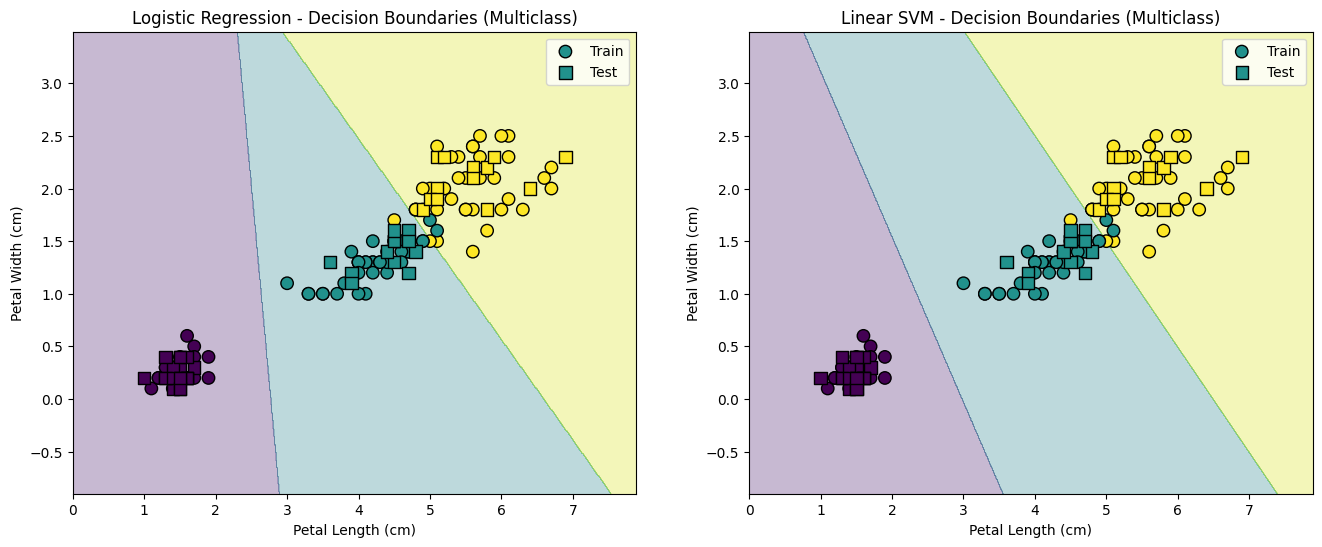

Logistic Regression Accuracy: 1.0
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


Linear SVM Accuracy: 1.0
Linear SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

# Load the iris dataset
iris = load_iris()
X = iris.data[:, 2:]  # Using only the first two features for visualization
y = iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Logistic Regression classifier
logreg_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Train the Logistic Regression classifier
logreg_classifier.fit(X_train, y_train)

# Initialize the Linear SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the Linear SVM classifier
svm_classifier.fit(X_train, y_train)

# Visualize the decision boundaries for Logistic Regression
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Decision boundaries for Logistic Regression
Z_logreg = logreg_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z_logreg = Z_logreg.reshape(xx.shape)

# Decision boundaries for Linear SVM
Z_svm = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z_svm = Z_svm.reshape(xx.shape)

# Plotting
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z_logreg, alpha=0.3, cmap='viridis')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolors='k', marker='o', s=80, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', edgecolors='k', marker='s', s=80, label='Test')
plt.title('Logistic Regression - Decision Boundaries (Multiclass)')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.legend()

plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z_svm, alpha=0.3, cmap='viridis')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis', edgecolors='k', marker='o', s=80, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', edgecolors='k', marker='s', s=80, label='Test')
plt.title('Linear SVM - Decision Boundaries (Multiclass)')
plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.legend()

plt.show()

# Evaluate Logistic Regression
y_pred_logreg = logreg_classifier.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
classification_report_logreg = classification_report(y_test, y_pred_logreg)

# Evaluate Linear SVM
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_report_svm = classification_report(y_test, y_pred_svm)

print("Logistic Regression Accuracy:", accuracy_logreg)
print("Logistic Regression Classification Report:\n", classification_report_logreg)

print("\nLinear SVM Accuracy:", accuracy_svm)
print("Linear SVM Classification Report:\n", classification_report_svm)

